1- EĞİTİM VE TEST VERİLERİNİ ANALİZ ETME

In [1]:
import pandas as pd
import os
import sys

# GARANTİ YOL BULMA (Path Safety)
# Notebooks klasöründen bir üste (Proje Köküne) çıkıyoruz
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Eğer VS Code root'ta açtıysa düzeltme yap:
if os.path.basename(os.getcwd()) != "notebooks":
    PROJECT_ROOT = os.getcwd()

# Verilerin olduğu ana yer
RAW_DIR = os.path.join(PROJECT_ROOT, 'data', 'raw')

# NOT: Zip dosyası bazen "Train" klasörü oluşturur, bazen oluşturmaz. Bunu otomatik kontrol edelim:
if os.path.exists(os.path.join(RAW_DIR, "Train")):
    TRAIN_PATH = os.path.join(RAW_DIR, "Train")
else:
    TRAIN_PATH = RAW_DIR # Klasör yoksa dosyalar direkt raw içindedir

print(f"Proje Kökü: {PROJECT_ROOT}")
print(f"Veri Yolu : {TRAIN_PATH}")

# VERİLERİ YÜKLEME
try:
    print("\nVeriler okunuyor...")
    
    # Cevap Anahtarı (Train Terms) - path'i dinamik olarak oluşturuyoruz
    term_file = os.path.join(TRAIN_PATH, 'train_terms.tsv')
    df_train_terms = pd.read_csv(term_file, sep='\t')
    
    # Puan Cetveli (IA.tsv) - Genelde raw klasörünün hemen içinde olur
    ia_file = os.path.join(RAW_DIR, 'IA.tsv')
    df_ia = pd.read_csv(ia_file, sep='\t', header=None, names=['term', 'IA'])
    
    print("Veriler hafızaya yüklendi!")

    # --- ANALİZ VE ÖZET ---
    print(f"\n--- 1. Eğitim Seti (Cevap Anahtarı) ---")
    print(f"Toplam Satır: {len(df_train_terms):,}")
    display(df_train_terms.head())

    print(f"\n--- 2. Puan Cetveli (IA) ---")
    print(f"Toplam Terim: {len(df_ia):,}")
    display(df_ia.head())

    # İstatistik: En çok geçen 5 etiket
    print("\n--- 3. En Çok Rastlanan 5 İşlev (GO Terimi) ---")
    top_5 = df_train_terms['term'].value_counts().head(5)
    print(top_5)
    
except FileNotFoundError as e:
    print(f"\nHATA: Dosya bulunamadı!\n{e}")
    print("Lütfen klasör yapısını sol panelden kontrol et.")

Proje Kökü: /Users/denbay/Desktop/Cafa-6
Veri Yolu : /Users/denbay/Desktop/Cafa-6/data/raw/Train

Veriler okunuyor...
Veriler hafızaya yüklendi!

--- 1. Eğitim Seti (Cevap Anahtarı) ---
Toplam Satır: 537,027


,EntryID,term,aspect
0,Q5W0B1,GO:0000785,C
1,Q5W0B1,GO:0004842,F
2,Q5W0B1,GO:0051865,P
3,Q5W0B1,GO:0006275,P
4,Q5W0B1,GO:0006513,P



--- 2. Puan Cetveli (IA) ---
Toplam Terim: 40,122


,term,IA
0,GO:0000001,0.000000
1,GO:0000002,2.849666
2,GO:0000011,0.137504
3,GO:0000012,6.038630
4,GO:0000017,0.514573



--- 3. En Çok Rastlanan 5 İşlev (GO Terimi) ---
term
GO:0005515    33713
GO:0005634    13283
GO:0005829    13040
GO:0005886    10150
GO:0005737     9442
Name: count, dtype: int64


örneğin burada "0005515" terimi 33713 kere geçmiş en çok rastlanan terimdir.

2- HAZİNE HARİTASI (EN ÇOK PUAN NEREDE ?)

Analiz edilecek terim sayısı: 26125


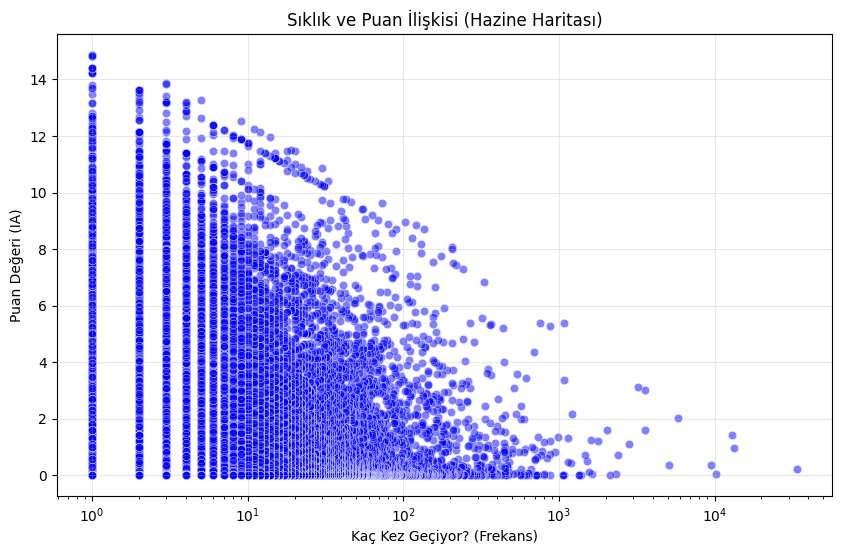

Korelasyon Katsayısı: -0.0253


In [2]:
# --- FREKANS vs PUAN ANALİZİ ---
import matplotlib.pyplot as plt
import seaborn as sns

# Hangi terim kaç kere geçmiş hesaplayalım
term_counts = df_train_terms['term'].value_counts().reset_index()
term_counts.columns = ['term', 'frequency'] # TERİM, FREKANSI

# Bu sayıları, Puan tablosuyla (df_ia) birleştirelim
# 'inner': Sadece her iki tabloda da olanları al
df_plot = pd.merge(term_counts, df_ia, on='term', how='inner')

print(f"Analiz edilecek terim sayısı: {len(df_plot)}")

# Grafiği Çizelim
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='frequency', y='IA', alpha=0.5, color='blue')

plt.title('Sıklık ve Puan İlişkisi (Hazine Haritası)')
plt.xlabel('Kaç Kez Geçiyor? (Frekans)')
plt.ylabel('Puan Değeri (IA)')
plt.xscale('log') # Logaritmik ölçek (Çok büyük sayıları sıkıştırmak için)
plt.grid(True, alpha=0.3)
plt.show()

# Korelasyon (İlişki) Sayısı
correlation = df_plot['frequency'].corr(df_plot['IA'])
print(f"Korelasyon Katsayısı: {correlation:.4f}")
# -1'e yakınsa: Biri artarken diğeri azalıyor demektir (Ters orantı).

Yaygınlık arttıkça, değer azalıyor. her nadir şey değerli değil, ama her değerli şey nadir. sol üst köşe hazinedir.

3- PROTEİNLERİN UZUNLUK BİLGİLERİ

Protein dizileri okunuyor: /Users/denbay/Desktop/Cafa-6/data/raw/Train/train_sequences.fasta

--- Dizi İstatistikleri ---
Toplam Protein : 82,404
En Kısa        : 3
En Uzun        : 35213
Ortalama       : 526


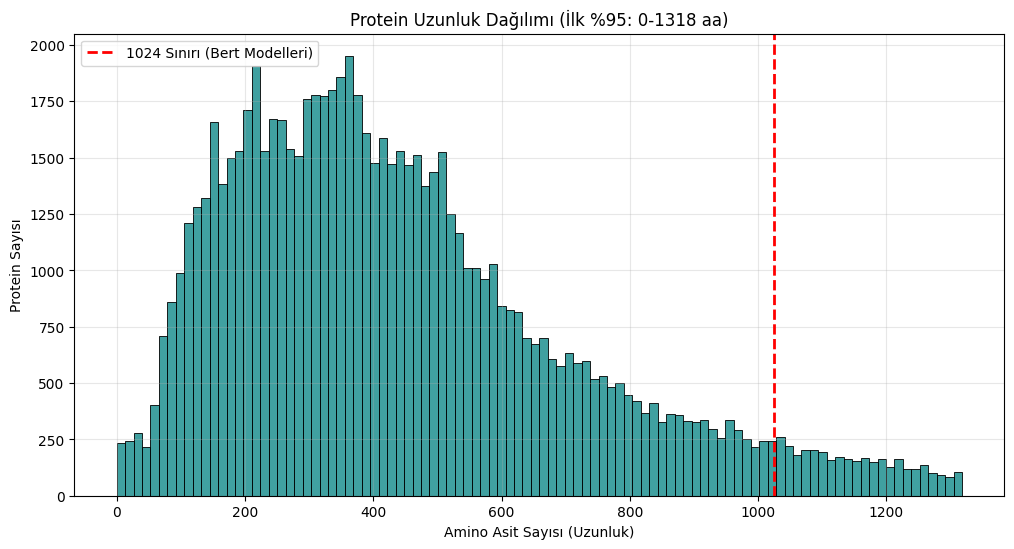

⚠️ 1024'ten uzun protein sayısı: 7623 (%9.25)


In [3]:
#Protein Dizi Uzunluk Analizi (Model Sınırlarını Belirleme)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Fasta okuma fonksiyonu
def read_fasta_lengths(fasta_path): # sadece fasta dosyasının yolunu alacak
    lengths = []
    current_length = 0
    
    with open(fasta_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'): # Başlık satırı
                if current_length > 0:
                    lengths.append(current_length)
                current_length = 0
            else:
                current_length += len(line)
        # Son proteini eklemeyi unutma
        if current_length > 0:
            lengths.append(current_length)
    return lengths

# DOSYA YOLUNU GÜVENLİ HALE GETİRİYORUZ
# Önceki hücrede tanımladığımız 'TRAIN_PATH' değişkenini kullanıyoruz
fasta_file = os.path.join(TRAIN_PATH, "train_sequences.fasta")

if os.path.exists(fasta_file):
    print(f"Protein dizileri okunuyor: {fasta_file}")
    seq_lengths = read_fasta_lengths(fasta_file)

    # İSTATİSTİKLER
    print(f"\n--- Dizi İstatistikleri ---")
    print(f"Toplam Protein : {len(seq_lengths):,}")
    print(f"En Kısa        : {min(seq_lengths)}")
    print(f"En Uzun        : {max(seq_lengths)}")
    print(f"Ortalama       : {sum(seq_lengths) / len(seq_lengths):.0f}")

    # GÖRSELLEŞTİRME
    plt.figure(figsize=(12, 6))
    
    # Grafiği bozan aşırı uçları (outlier) görselden kırpalım (%95'ini görelim)
    limit = sorted(seq_lengths)[int(len(seq_lengths) * 0.95)]

    sns.histplot(seq_lengths, bins=100, binrange=(0, limit), color='teal')
    plt.title(f'Protein Uzunluk Dağılımı (İlk %95: 0-{limit} aa)')
    plt.xlabel('Amino Asit Sayısı (Uzunluk)')
    plt.ylabel('Protein Sayısı')
    
    # Kritik Eşik Çizgisi (Çoğu AI modeli 1024 karakter sınırına sahiptir)
    plt.axvline(x=1024, color='red', linestyle='--', linewidth=2, label='1024 Sınırı (Bert Modelleri)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Kritik Soru: 1024'ten uzun kaç protein var?
    long_proteins = sum(1 for x in seq_lengths if x > 1024)
    ratio = (long_proteins / len(seq_lengths)) * 100
    print(f"⚠️ 1024'ten uzun protein sayısı: {long_proteins} (%{ratio:.2f})")
    
else:
    print(f"HATA: Dosya bulunamadı: {fasta_file}")
    print("Lütfen 'data/raw' klasörünü kontrol et.")

listenin %95 i 1024 uzunluğu solunda bu bölgede arama yapacağız. her etiketi tahmin etmek imkansız ve gereksiz. başlangıç olarak en sık geçen 1500 etiket ile başlayacağız

In [4]:
# İşlemci (Processor) Testi
# src dosyasındaki data_processor.py modülü testi
import sys
import os

# Python'a 'src' klasörünü tanıtıyoruz ki import edebilelim
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Senin yazdığın modülü çağırıyoruz
from src.data_processor import CafaProcessor

print("Modül başarıyla import edildi!")

# 1. İşlemciyi Başlat (Otomatik yol buluculu)
processor = CafaProcessor(project_root=PROJECT_ROOT, num_labels=50)

# 2. Etiketleri Yükle
processor.load_labels()

# 3. Örnek Bir Protein Kodla
ornek_protein = "MKAWLVLVGVL"
kodlanmis = processor.encode_sequence(ornek_protein)

print(f"\nOrijinal: {ornek_protein}")
print(f"Sayısal : {kodlanmis[:15]}") # İlk 15 hane
print(f"Uzunluk : {len(kodlanmis)} (1024 olmalı)")

Modül başarıyla import edildi!
Etiket dosyası okunuyor: /Users/denbay/Desktop/Cafa-6/data/raw/Train/train_terms.tsv
En yaygın 50 etiket seçiliyor...
Etiket haritası hazır.

Orijinal: MKAWLVLVGVL
Sayısal : [11  9  1 19 10 18 10 18  6 18 10  0  0  0  0]
Uzunluk : 1024 (1024 olmalı)


In [5]:
# Processor dosyasına dataset sınıfı testi
import os
import sys

# 1. ÖNCE YOLU BUL VE TARİF ET
current_dir = os.getcwd()
if os.path.basename(current_dir) == "notebooks":
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

# Python'ın arama listesine bu yolu ekle (IMPORT'TAN ÖNCE YAPILMALI)
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"📍 Yol Eklendi: {project_root}")

# 2. ŞİMDİ IMPORT ET (Artık yolu biliyor)
try:
    from src.data_processor import CafaProcessor, CafaDataset
    import torch
    print("Modüller başarıyla yüklendi!")
except ImportError as e:
    print(f"HATA: {e}")

# 3. TESTİ BAŞLAT
# İşlemciyi Hazırla
processor = CafaProcessor(project_root=project_root, num_labels=50) # Hız için 50 etiket

# Verileri Yükle
df_terms = processor.load_labels()
seqs_dict = processor.load_fasta()

# Hem dizisi hem etiketi olan proteinleri bul
common_ids = list(set(df_terms['EntryID']) & set(seqs_dict.keys()))
print(f"Kullanılabilir Eğitim Verisi: {len(common_ids)}")

if len(common_ids) > 0:
    # Garsonu Göreve Çağır (Dataset Oluştur)
    train_dataset = CafaDataset(processor, common_ids[:100], seqs_dict, df_terms)

    # İLK SİPARİŞİ KONTROL ET
    sample = train_dataset[0]

    print("\n--- ÖRNEK TENSÖR ÇIKTISI ---")
    print(f"Input Shape (Dizi)   : {sample['input_ids'].shape} -> (1024 olmalı)")
    print(f"Label Shape (Etiket) : {sample['labels'].shape} -> (50 olmalı)")
    print("Garson tepsiyi (Tensorları) doğru hazırladı!")
else:
    print("⚠️ HATA: Ortak ID bulunamadı. Fasta ve TSV eşleşmiyor.")

✅ Modüller başarıyla yüklendi!
Etiket dosyası okunuyor: /Users/denbay/Desktop/Cafa-6/data/raw/Train/train_terms.tsv
En yaygın 50 etiket seçiliyor...
Etiket haritası hazır.
Fasta okunuyor: /Users/denbay/Desktop/Cafa-6/data/raw/Train/train_sequences.fasta
82404 protein hafızaya alındı.
🔗 Kullanılabilir Eğitim Verisi: 63264
⚙️ Veriler eşleştiriliyor (Etiketleme)...

--- ÖRNEK TENSÖR ÇIKTISI ---
Input Shape (Dizi)   : torch.Size([1024]) -> (1024 olmalı)
Label Shape (Etiket) : torch.Size([50]) -> (50 olmalı)
🎉 Garson tepsiyi (Tensorları) doğru hazırladı!


In [2]:
# --- MODEL TEST ---
import os
import sys
import torch

# Yol
current_dir = os.getcwd()
if os.path.basename(current_dir) == "notebooks":
    project_root = os.path.dirname(current_dir)
    sys.path.append(project_root)

# Modeli Çağır
try:
    from src.model import CafaCNN
    print("Model dosyası başarıyla bulundu!")
except ImportError as e:
    print(f"HATA: {e}")

# Modeli Başlat
# num_labels=50 yapıyoruz çünkü processor testinde 50 seçmiştik.
model = CafaCNN(num_labels=50) 
print("Model Mimarisi Hazır!")

# Rastgele Bir Veriyle Dene (Simülasyon)
# 4 tane protein, 1024 uzunluğunda
dummy_input = torch.randint(0, 21, (4, 1024)) 

# İleri Besleme (Forward Pass)
try:
    output = model(dummy_input)
    print("\n--- TEST SONUÇLARI ---")
    print(f"Girdi Boyutu : {dummy_input.shape} (4 Protein, 1024 Uzunluk)")
    print(f"Çıktı Boyutu : {output.shape} (Her protein için 50 tahmin)")
    
    if output.shape == (4, 50):
        print("\nMÜKEMMEL! Modelin beyni sorunsuz çalışıyor.")
        print("Boyutlar tam istediğimiz gibi aktı.")
    else:
        print("⚠️ HATA: Çıktı boyutu beklenen gibi değil.")
except Exception as e:
    print(f"\nÇALIŞMA HATASI: {e}")

Model dosyası başarıyla bulundu!
Model Mimarisi Hazır!

--- TEST SONUÇLARI ---
Girdi Boyutu : torch.Size([4, 1024]) (4 Protein, 1024 Uzunluk)
Çıktı Boyutu : torch.Size([4, 50]) (Her protein için 50 tahmin)

MÜKEMMEL! Modelin beyni sorunsuz çalışıyor.
Boyutlar tam istediğimiz gibi aktı.


In [1]:
# EĞİTİM DOSYASI TESTİ - Terminal Komutu Olarak Test Edilecek
!python ../src/train.py

🚀 Cihaz: Apple M1/M2/M3 (MPS) - Turbo Modu Aktif!

📊 Veriler Yükleniyor...
Etiket dosyası okunuyor: /Users/denbay/Desktop/Cafa-6/data/raw/Train/train_terms.tsv
En yaygın 1500 etiket seçiliyor...
Etiket haritası hazır.
Fasta okunuyor: /Users/denbay/Desktop/Cafa-6/data/raw/Train/train_sequences.fasta
82404 protein hafızaya alındı.
🔗 Eğitim için 76294 protein eşleşti.
⚙️ Veriler eşleştiriliyor (Etiketleme)...

🧠 Model İnşa Ediliyor...

🔥 Eğitim Başlıyor! (5 Tur)
Epoch [1/5], Adım [100/2385], Hata: 0.0161
Epoch [1/5], Adım [200/2385], Hata: 0.0220
Epoch [1/5], Adım [300/2385], Hata: 0.0157
Epoch [1/5], Adım [400/2385], Hata: 0.0220
Epoch [1/5], Adım [500/2385], Hata: 0.0154
Epoch [1/5], Adım [600/2385], Hata: 0.0149
Epoch [1/5], Adım [700/2385], Hata: 0.0197
Epoch [1/5], Adım [800/2385], Hata: 0.0148
Epoch [1/5], Adım [900/2385], Hata: 0.0175
Epoch [1/5], Adım [1000/2385], Hata: 0.0200
Epoch [1/5], Adım [1100/2385], Hata: 0.0146
Epoch [1/5], Adım [1200/2385], Hata: 0.0110
Epoch [1/5], Adım

fatsa -> proteinler , tsv -> proteinlerin ne işe yaradıkları cevap anahtarı. şimdi fatsada işi bilinmeyen yani tsv de kaydı olmayan binlerce protein var. tsv de de iş var ancak yapanı belli olmayan olaylar var. Eğitimde bu eşleşmesizlikler sıkıntı yaratacağıncan biz sadece kim-ne yapıyor belli olan yani bunların kesişim kümelerini aldık. Bu da toplamda 76.294 adetmiş. Bunlar üzerinden 3 Adımlı bir eğitim döngüsü başlattık (train.py dosyasında)

ÇIKTI : Çıktıda 1.epoch (döngü) sonucu ile son sonuç neredeyse aynı yani eğitim normalde yüksek hata oranı le başlayıp küçülmeye devam etmesi gerekirken saten çok küçük değerle başlayarak o şekilde devam ediyor. Bu da eğitim sırasında her protein için 1500 etiket den birkaçı eşletirme ihtimali var bunlara yüksek değer verecek diğer kalan nerdeyse 1490 civarındaki etikete düşük değerler verecek. Model aman yanlışlık olmasın diye riske girmemek için düşük değer vermesi gerekenlere direkt 0 vermiş olabilir bunu için tembellik edip etmediği kontrolünü verdiği değer vektörlerine bakarak anlayacağız. (predict.py dosyası bunu yapacak)

In [3]:
!python ../src/predict.py

🚀 Tahmin Motoru Başlatılıyor (Cihaz: mps)
📖 Sözlük (Etiketler) yükleniyor...
Etiket dosyası okunuyor: /Users/denbay/Desktop/Cafa-6/data/raw/Train/train_terms.tsv
En yaygın 1500 etiket seçiliyor...
Etiket haritası hazır.
🧠 Model yükleniyor: cafa_model_v1.pth
✅ Model hazır!

🧪 Test için rastgele bir protein seçiliyor...
Fasta okunuyor: /Users/denbay/Desktop/Cafa-6/data/raw/Train/train_sequences.fasta
82404 protein hafızaya alındı.
🧬 Protein ID : Q9DCR4
📏 Uzunluk    : 169 amino asit
📝 Dizi (İlk 50): MAEMAELCELYEESNELQMDVLPGEGYMEVGRGARGPAPEEGPMEEEAGP...

🔍 MODELİN TAHMİNLERİ:
----------------------------------------
🏆 GO:0005515 : %30.33 İhtimal
🏆 GO:0005829 : %3.77 İhtimal
🏆 GO:0005737 : %1.32 İhtimal
----------------------------------------
ℹ️ Not: Bu tahminler, modelin eğitim setindeki 1500 etiketten öğrendikleridir.


ilk testte -> Uzunluk : 0 amoniasit diyor. yani işlemci dosyasındaki proteinleri ayıran ayraç simgelerini yanlış girmişisiz onun güncellemesi yapıldı.
2. test -> sorun çözüldü. amino asitleri okuyor ve vediğimiz bir örneği henüz 5 epoch çalıştırmamıza rağmen %30 doğru bildi iyi başarı görünüyor.

In [4]:
!python ../src/train.py

🚀 Cihaz: Apple M1/M2/M3 (MPS) - Turbo Modu Aktif!

📊 Veriler Yükleniyor...
Etiket dosyası okunuyor: /Users/denbay/Desktop/Cafa-6/data/raw/Train/train_terms.tsv
En yaygın 1500 etiket seçiliyor...
Etiket haritası hazır.
Fasta okunuyor: /Users/denbay/Desktop/Cafa-6/data/raw/Train/train_sequences.fasta
82404 protein hafızaya alındı.
🔗 Eğitim için 76294 protein eşleşti.
⚙️ Veriler eşleştiriliyor (Etiketleme)...

🧠 Model İnşa Ediliyor...

🔥 Eğitim Başlıyor! (5 Tur)
Epoch [1/5], Adım [100/2385], Hata: 0.0207
Epoch [1/5], Adım [200/2385], Hata: 0.0153
Epoch [1/5], Adım [300/2385], Hata: 0.0123
Epoch [1/5], Adım [400/2385], Hata: 0.0151
Epoch [1/5], Adım [500/2385], Hata: 0.0211
Epoch [1/5], Adım [600/2385], Hata: 0.0168
Epoch [1/5], Adım [700/2385], Hata: 0.0198
Epoch [1/5], Adım [800/2385], Hata: 0.0188
Epoch [1/5], Adım [900/2385], Hata: 0.0193
Epoch [1/5], Adım [1000/2385], Hata: 0.0176
Epoch [1/5], Adım [1100/2385], Hata: 0.0164
Epoch [1/5], Adım [1200/2385], Hata: 0.0150
Epoch [1/5], Adım

1.FAZ SONU. Bununla birlikte şuan 1.faz tamamlanmış oldu. 1- veri indirildi ve temizlendi 2- biyolojik veriler (fasta-tsv) vektörlere çevrildi (processing.py) 3- ai mimarisi kuruldu (1d cnn) 4- model eğitildi (train.py) 5- tahmni yapıp durum test edildi (predict.py)